# Artificial Intelligence Spring 2024-Project
## Lung cancer detection from CT images

### Group Members
- **Member 1 Name:** Laiba Ali &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **ID:** 169021077
- **Member 2 Name:** Aliha Ali &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **ID:** 210184090
- **Member 3 Name:** Arsalan Khan &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **ID:** 210862640
- **Member 4 Name:** Rhyme Her &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **ID:** 20157720

---

### Submission Date: August 2nd, 2024

All the listed members have contributed, read, and approved this submission.

- **Member 1 Name:** Laiba Ali &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Signature:** Laiba.Ali
- **Member 2 Name:** Aliha Ali &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Signature:** AA
- **Member 3 Name:** Arsalan Khan &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Signature:** AK
- **Member 4 Name:** Rhyme Her &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Signature:** RH

---

## Table of Contents

1. [Dataset Acknowledgement and Drive Information](#scrollTo=6zI5B80lWxoB)
2. [Setup and Installation](#scrollTo=dOpLUK87UF-p)
3. [Data Loading and Preprocessing](#scrollTo=xvDOWYtRtbGj)
4. [Simple CNN](#scrollTo=faSn9iECx-jA)
5. [Model 1: VGG](#model-1-vgg)
6. [Model 2: ResNet50](#scrollTo=ZfgvvGFVgUdt)
7. [Model 3: Inception](#scrollTo=9VGvmSRsgjNX)
8. [Gradio Interface](#scrollTo=TKpFho-pvamF)
9. [Evaluation and Reporting](#scrollTo=tmEbmyD9A8uS)
10. [Notes](#scrollTo=g_cdtZNfvwuX)
    - [URLs](#scrollTo=P1zC8R1xwA6s)
    - [Deliverables](#scrollTo=eyiYXliMsGnx)



# Dataset Acknowledgement and Drive Information

After researching different datasets to use and providing the appropriate references in our project proposal, we decided to settle on the "Chest CT-Scan images Dataset" provided by Mohamed Hany.

Here is a link to the dataset to view online: https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images

Here is a link to a drive folder: https://drive.google.com/drive/folders/1tnfhwUCrVwhXDg0Ie7xF1HiCFk3SLPKh?usp=sharing

### Description of the Dataset:
- **Image Formats**: Images are in JPG or PNG format to fit the model requirements.
- **Cancer Types**: The dataset includes images of three chest cancer types:
  - Adenocarcinoma
  - Large Cell Carcinoma
  - Squamous Cell Carcinoma
  - Additionally, there is a folder for normal cells.
- **Folder Structure**:
  - **Data Folder**: The main folder containing all subfolders.
  - **Subfolders**:
    - `test`: Represents the testing set.
    - `train`: Represents the training set.
    - `valid`: Represents the validation set.
- **Data Split**:
  - Training Set: 70%
  - Testing Set: 20%
  - Validation Set: 10%


# Setup and Installation


In [ ]:
# Setup and Installation required to run
!pip install pydicom gradio pillow tensorflow

import pydicom
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import gradio as gr
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from PIL import Image
import os
from google.colab import drive
from sklearn.model_selection import train_test_split


# Data Loading and Preprocessing


In [ ]:
# Data Loading and Preprocessing

# Mount Google Drive to Google colab
drive.mount('/content/drive')

# Define the data paths so that the file location is specified
base_data_path = '/content/drive/My Drive/Project Data/archive/data/'
train_path = os.path.join(base_data_path, 'train')
val_path = os.path.join(base_data_path, 'valid')
test_path = os.path.join(base_data_path, 'test')

# Define classes for the 3 cancer types we will be testing for and the non-cancerous type
classes = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Function to load file paths and labels
def load_data_paths(data_folder):
    file_paths = []
    labels = []
    for label, class_name in enumerate(classes):
        class_folder = os.path.join(data_folder, class_name)
        for file_name in os.listdir(class_folder):
            file_paths.append(os.path.join(class_folder, file_name))
            labels.append(label)
    return file_paths, labels

# Load train, validation, and test data paths and labels
train_files, train_labels = load_data_paths(train_path)
val_files, val_labels = load_data_paths(val_path)
test_files, test_labels = load_data_paths(test_path)

print(f"Training files: {len(train_files)}, Validation files: {len(val_files)}, Test files: {len(test_files)}")

# Function to load and preprocess images in RGB format
def load_image(file_path):
    img = Image.open(file_path).convert('RGB')
    return np.array(img)

def preprocess_image(image, target_size=(224, 224), model_type='resnet'):
    resized_img = cv2.resize(image, target_size)
    if model_type == 'resnet':
        img = preprocess_resnet(resized_img)
    elif model_type == 'inception':
        img = preprocess_inception(resized_img)
    elif model_type == 'vgg':
        img = preprocess_vgg(resized_img)
    return img

def load_and_preprocess_data(file_paths, model_type='resnet'):
    images = []
    for file_path in file_paths:
        image = load_image(file_path)
        if image is not None:
            preprocessed_img = preprocess_image(image, model_type=model_type)
            images.append(preprocessed_img)
    return np.array(images)

# Load and preprocess data for resnet and inception models
x_train_resnet = load_and_preprocess_data(train_files, model_type='resnet')
x_val_resnet = load_and_preprocess_data(val_files, model_type='resnet')
x_test_resnet = load_and_preprocess_data(test_files, model_type='resnet')

x_train_inception = load_and_preprocess_data(train_files, model_type='inception')
x_val_inception = load_and_preprocess_data(val_files, model_type='inception')
x_test_inception = load_and_preprocess_data(test_files, model_type='inception')

x_train_vgg = load_and_preprocess_data(train_files, model_type='vgg')
x_val_vgg = load_and_preprocess_data(val_files, model_type='vgg')
x_test_vgg = load_and_preprocess_data(test_files, model_type='vgg')

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)


Mounted at /content/drive
Training files: 464, Validation files: 72, Test files: 315


#Simple CNN

In [ ]:
# Model 1: Simple CNN

# Initialize Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    brightness_range=[0.8, 1.2],  # Added brightness variation
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Create data generators for training and validation
train_it_simple = train_datagen.flow(x_train_resnet, train_labels, batch_size=32)
val_it_simple = val_datagen.flow(x_val_resnet, val_labels, batch_size=32)

# Model Definition, Compilation, and Training for Simple CNN
simple_cnn = Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Added dropout layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Added dropout layer
    Dense(4, activation='softmax')
])

simple_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # Adjusted learning rate
                   loss='sparse_categorical_crossentropy', metrics=['accuracy'])

simple_cnn.fit(train_it_simple, epochs=50, validation_data=val_it_simple, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

# For our Simple CNN we decided to go for 50 epochs and set a patience level of 10, having the patience level of 10 was done so if the val_loss is not changing it would be redundant to continue.
# This method essentially stops overfitting by using Early Stopping that "stops" data processing that will be harmful for generalization.


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.3457 - loss: 18.6757 - val_accuracy: 0.3056 - val_loss: 6.4429
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.4017 - loss: 10.2628 - val_accuracy: 0.3611 - val_loss: 2.9875
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.3485 - loss: 8.3938 - val_accuracy: 0.3750 - val_loss: 1.8057
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.4019 - loss: 4.4958 - val_accuracy: 0.3750 - val_loss: 1.4527
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.3518 - loss: 2.4921 - val_accuracy: 0.3472 - val_loss: 1.2957
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.3291 - loss: 1.8279 - val_accuracy: 0.3194 - val_loss: 1.3326
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.4308 - loss: 1.4954 - val_accuracy: 0.3750 - val_loss: 1.2815
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.4133 - loss: 1.3887 - val_accuracy: 0.4444 - val_loss: 1.2752


# Model 1: VGG16

In [ ]:
# Model 1: VGG

# Create data generators for training and validation
train_it_vgg = train_datagen.flow(x_train_vgg, train_labels, batch_size=32)
val_it_vgg = val_datagen.flow(x_val_vgg, val_labels, batch_size=32)

# Model Definition, Compilation, and Training for VGG16
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
vgg_base.trainable = False

# Add custom layers on top
x = vgg_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

vgg_model = Model(inputs=vgg_base.input, outputs=predictions)

# Compile the model
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the training and validation data generators
vgg_model.fit(train_it_vgg, epochs=30, validation_data=val_it_vgg, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 356s 23s/step - accuracy: 0.3919 - loss: 1.8158 - val_accuracy: 0.4722 - val_loss: 1.7975
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 386s 24s/step - accuracy: 0.5256 - loss: 1.0694 - val_accuracy: 0.5417 - val_loss: 1.7058
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 377s 23s/step - accuracy: 0.6355 - loss: 0.9249 - val_accuracy: 0.5000 - val_loss: 1.5951
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 356s 24s/step - accuracy: 0.7031 - loss: 0.7858 - val_accuracy: 0.5139 - val_loss: 1.4150
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 354s 24s/step - accuracy: 0.6456 - loss: 0.8468 - val_accuracy: 0.5139 - val_loss: 1.4801
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 355s 23s/step - accuracy: 0.7430 - loss: 0.6616 - val_accuracy: 0.5556 - val_loss: 1.2033
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 381s 24s/step - accuracy: 0.7276 - loss: 0.7184 - val_accuracy: 0.5556 - val_loss: 1.2849
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 390s 26s/step -

# Model 2 ResNet50


In [ ]:
# Model 2: ResNet50

# Create data generators for training and validation
train_it_resnet = train_datagen.flow(x_train_resnet, train_labels, batch_size=32)
val_it_resnet = val_datagen.flow(x_val_resnet, val_labels, batch_size=32)

# Model Definition, Compilation, and Training for ResNet50
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
resnet_base.trainable = False

# Add custom layers on top
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

resnet_model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the training and validation data generators
resnet_model.fit(train_it_resnet, epochs=35, validation_data=val_it_resnet, callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

#For our Resnet50 model we decided to go for 35 epochs and set a patience level of 5, having the patience level of 5 was done so if the val_loss is not changing it would redundant to continue.
#This method essentially stops overfitting by using  Early Stopping that "stops" data processing that will be harmful for generalization



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 123s 7s/step - accuracy: 0.4906 - loss: 1.2175 - val_accuracy: 0.5139 - val_loss: 1.0479
Epoch 2/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step - accuracy: 0.6295 - loss: 0.8626 - val_accuracy: 0.5556 - val_loss: 1.0937
Epoch 3/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - accuracy: 0.7065 - loss: 0.7421 - val_accuracy: 0.4722 - val_loss: 1.1680
Epoch 4/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 119s 8s/step - accuracy: 0.6964 - loss: 0.7639 - val_accuracy: 0.6111 - val_loss: 1.0291
Epoch 5/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy: 0.7276 - loss: 0.6774 - val_accuracy: 0.5139 - val_loss: 1.0444
Epoch 6/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.7120 - loss: 0.6977 - val_accuracy: 0.5000 - val_loss: 1.0344
Epoch 7/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.7467 - loss: 0.6549 - val_accuracy: 0.5000 - val_loss: 1.2033
Epoch 8/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - accurac

# Model 3: Inception

In [ ]:
# Model 3: InceptionV3

# Create data generators for training and validation
train_it_inception = train_datagen.flow(x_train_inception, train_labels, batch_size=32)
val_it_inception = val_datagen.flow(x_val_inception, val_labels, batch_size=32)

# Model Definition, Compilation, and Training for Inception
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
inception_base.trainable = False

# Add custom layers on top
x = inception_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

inception_model = Model(inputs=inception_base.input, outputs=predictions)

# Compile the model
inception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the training and validation data generators
inception_model.fit(train_it_inception, epochs=35, validation_data=val_it_inception, callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.3751 - loss: 1.3716 - val_accuracy: 0.4306 - val_loss: 1.3570
Epoch 2/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.6330 - loss: 0.9547 - val_accuracy: 0.4722 - val_loss: 1.2522
Epoch 3/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.6089 - loss: 0.9828 - val_accuracy: 0.4722 - val_loss: 1.2225
Epoch 4/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.6281 - loss: 0.9076 - val_accuracy: 0.6250 - val_loss: 1.1690
Epoch 5/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.6698 - loss: 0.8425 - val_accuracy: 0.5694 - val_loss: 1.1476
Epoch 6/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.6200 - loss: 0.8638 - val_accuracy: 0.5417 - val_loss: 1.1776
Epoch 7/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.6213 - loss: 0.8964 - val_accuracy: 0.5139 - val_loss: 1.2031
Epoch 8/35
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.64

# Gradio Interface


In [ ]:
import gradio as gr
import numpy as np
from PIL import Image
import cv2

# Gradio Interface with Ensemble

def classify_image(file):
    try:
        img = Image.open(file).convert('RGB')
        img_array = np.array(img)

        img_resized = cv2.resize(img_array, (224, 224))
        img_normalized_vgg = preprocess_vgg(img_resized).reshape(1, 224, 224, 3)
        img_normalized_resnet = preprocess_resnet(img_resized).reshape(1, 224, 224, 3)
        img_normalized_inception = preprocess_inception(img_resized).reshape(1, 224, 224, 3)

        prediction_vgg = vgg_model.predict(img_normalized_vgg)
        prediction_resnet = resnet_model.predict(img_normalized_resnet)
        prediction_inception = inception_model.predict(img_normalized_inception)

        ensemble_prediction = (prediction_vgg + prediction_resnet + prediction_inception) / 3
        classes = ['Adenocarcinoma', 'Large Cell Carcinoma', 'Normal', 'Squamous Cell Carcinoma']
        predicted_class = classes[np.argmax(ensemble_prediction)]

        return {predicted_class: float(np.max(ensemble_prediction))}, img
    except Exception as e:
        return f"Error reading file: {e}", None

# Custom CSS for dark theme and layout
css = """
body {
    background-color: #2E2E2E;
    color: white;
    font-family: Arial, sans-serif;
}
h1 {
    color: #FFD700;
}
label, .gr-button {
    background-color: #333333;
    border: none;
    color: white;
}
"""

# Title and Group Information
title = """
<h1>Artificial Intelligence Spring 2024-Project</h1>
<h2>Lung cancer detection from CT images</h2>
<p><strong>Group Members</strong><br>
Member 1 Name: Laiba Ali &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ID: 169021077<br>
Member 2 Name: Aliha Ali &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ID: 210184090<br>
Member 3 Name: Arsalan Khan &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ID: 210862640<br>
Member 4 Name: Rhyme Her &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ID: 20157720
</p>
"""

iface = gr.Interface(
    fn=classify_image,
    inputs=gr.File(label="Upload JPG or PNG File"),
    outputs=[gr.Label(label="Prediction"), gr.Image(label="Preview")],
    live=True,
    allow_flagging='never',
    css=css,
    title=title
)

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://8bac93752b871a63f5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Evaluation and Reporting

Evaluating Simple CNN...
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3663 - loss: 1.1484
Simple CNN - Test Loss: 1.3087962865829468
Simple CNN - Test Accuracy: 0.3492063581943512
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 935ms/step
Simple CNN - Confusion Matrix:
 [[37 83  0  0]
 [11 40  0  0]
 [ 8 13 33  0]
 [29 61  0  0]]
Simple CNN - Classification Report:
                          precision    recall  f1-score   support

         adenocarcinoma       0.44      0.31      0.36       120
   large.cell.carcinoma       0.20      0.78      0.32        51
                 normal       1.00      0.61      0.76        54
squamous.cell.carcinoma       0.00      0.00      0.00        90

               accuracy                           0.35       315
              macro avg       0.41      0.43      0.36       315
           weighted avg       0.37      0.35      0.32       315



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


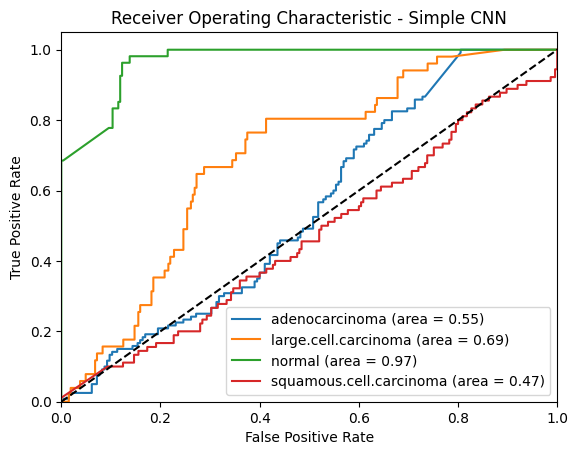

Evaluating VGG...
10/10 ━━━━━━━━━━━━━━━━━━━━ 206s 20s/step - accuracy: 0.4928 - loss: 1.2075
VGG - Test Loss: 1.066870927810669
VGG - Test Accuracy: 0.5492063760757446
10/10 ━━━━━━━━━━━━━━━━━━━━ 205s 20s/step
VGG - Confusion Matrix:
 [[44 64  0 12]
 [ 0 49  0  2]
 [ 0  0 53  1]
 [24 39  0 27]]
VGG - Classification Report:
                          precision    recall  f1-score   support

         adenocarcinoma       0.65      0.37      0.47       120
   large.cell.carcinoma       0.32      0.96      0.48        51
                 normal       1.00      0.98      0.99        54
squamous.cell.carcinoma       0.64      0.30      0.41        90

               accuracy                           0.55       315
              macro avg       0.65      0.65      0.59       315
           weighted avg       0.65      0.55      0.54       315



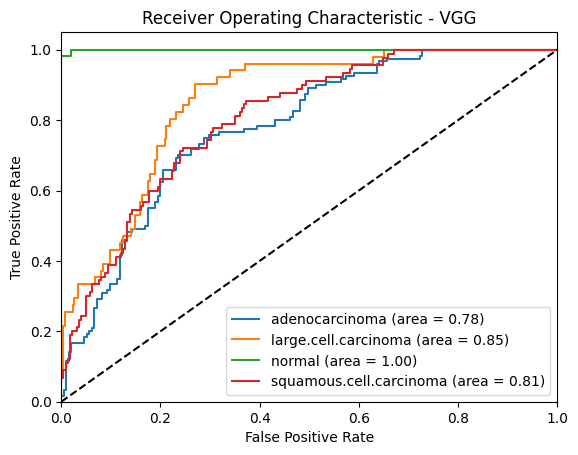

Evaluating ResNet50...
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.7877 - loss: 0.6838
ResNet50 - Test Loss: 1.0036576986312866
ResNet50 - Test Accuracy: 0.5873016119003296
10/10 ━━━━━━━━━━━━━━━━━━━━ 65s 6s/step
ResNet50 - Confusion Matrix:
 [[111   9   0   0]
 [ 30  21   0   0]
 [  1   0  53   0]
 [ 75  15   0   0]]
ResNet50 - Classification Report:
                          precision    recall  f1-score   support

         adenocarcinoma       0.51      0.93      0.66       120
   large.cell.carcinoma       0.47      0.41      0.44        51
                 normal       1.00      0.98      0.99        54
squamous.cell.carcinoma       0.00      0.00      0.00        90

               accuracy                           0.59       315
              macro avg       0.49      0.58      0.52       315
           weighted avg       0.44      0.59      0.49       315



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


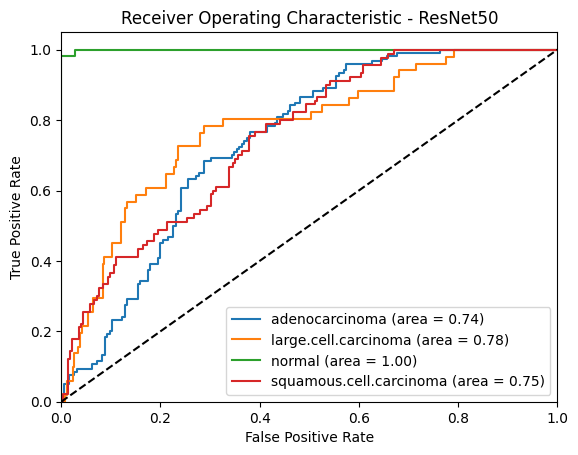

Evaluating InceptionV3...
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6705 - loss: 0.8003
InceptionV3 - Test Loss: 1.107257604598999
InceptionV3 - Test Accuracy: 0.561904788017273
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step
InceptionV3 - Confusion Matrix:
 [[87 31  1  1]
 [15 35  1  0]
 [ 3  1 50  0]
 [54 26  5  5]]
InceptionV3 - Classification Report:
                          precision    recall  f1-score   support

         adenocarcinoma       0.55      0.72      0.62       120
   large.cell.carcinoma       0.38      0.69      0.49        51
                 normal       0.88      0.93      0.90        54
squamous.cell.carcinoma       0.83      0.06      0.10        90

               accuracy                           0.56       315
              macro avg       0.66      0.60      0.53       315
           weighted avg       0.66      0.56      0.50       315



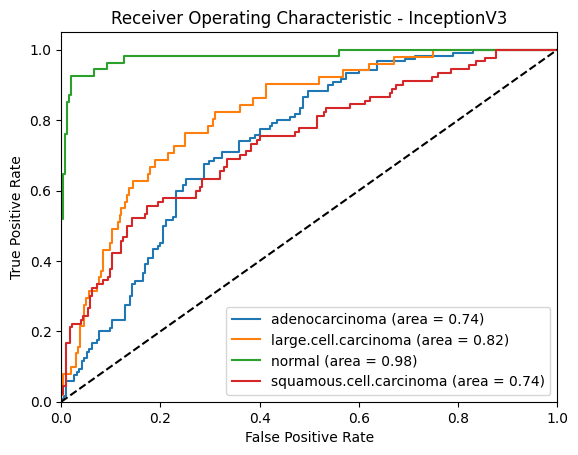

Evaluating Ensemble Model...
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 947ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 204s 20s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step
Ensemble Model - Confusion Matrix:
 [[65 47  8  0]
 [ 1 45  4  1]
 [ 0  0 54  0]
 [38 28 17  7]]
Ensemble Model - Classification Report:
                          precision    recall  f1-score   support

         adenocarcinoma       0.62      0.54      0.58       120
   large.cell.carcinoma       0.38      0.88      0.53        51
                 normal       0.65      1.00      0.79        54
squamous.cell.carcinoma       0.88      0.08      0.14        90

               accuracy                           0.54       315
              macro avg       0.63      0.63      0.51       315
           weighted avg       0.66      0.54      0.48       315



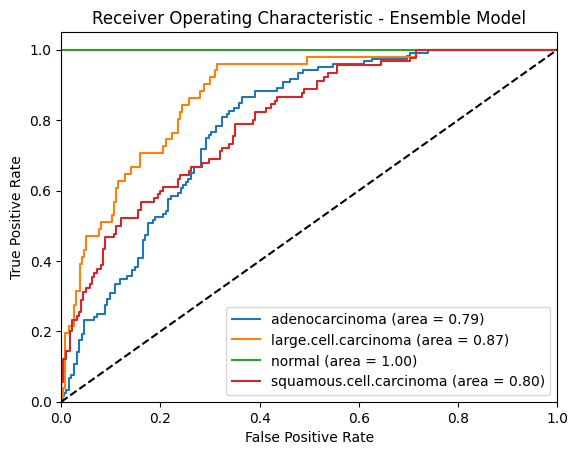

In [ ]:
# Evaluation and Reporting

def evaluate_and_report(model, x_test, test_labels, model_name):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test, test_labels)
    print(f"{model_name} - Test Loss: {test_loss}")
    print(f"{model_name} - Test Accuracy: {test_accuracy}")

    # Generate predictions
    predictions = model.predict(x_test)
    predicted_classes = np.argmax(predictions, axis=1)  # For multi-class classification

    # Generate confusion matrix and classification report
    cm = confusion_matrix(test_labels, predicted_classes)
    print(f"{model_name} - Confusion Matrix:\n", cm)

    clr = classification_report(test_labels, predicted_classes, target_names=classes)
    print(f"{model_name} - Classification Report:\n", clr)

    # Plot ROC Curve for each class
    plt.figure()
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(test_labels == i, predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{classes[i]} (area = {roc_auc:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate Simple CNN
print("Evaluating Simple CNN...")
evaluate_and_report(simple_cnn, x_test_resnet, test_labels, "Simple CNN")

# Evaluate VGG
print("Evaluating VGG...")
evaluate_and_report(vgg_model, x_test_vgg, test_labels, "VGG")

# Evaluate ResNet50
print("Evaluating ResNet50...")
evaluate_and_report(resnet_model, x_test_resnet, test_labels, "ResNet50")

# Evaluate InceptionV3
print("Evaluating InceptionV3...")
evaluate_and_report(inception_model, x_test_inception, test_labels, "InceptionV3")

# Ensemble Evaluation
def evaluate_ensemble(models, x_test, test_labels, model_names):
    predictions = [model.predict(x_test) for model in models]
    ensemble_predictions = np.mean(predictions, axis=0)
    predicted_classes = np.argmax(ensemble_predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_classes)
    print("Ensemble Model - Confusion Matrix:\n", cm)

    clr = classification_report(test_labels, predicted_classes, target_names=classes)
    print("Ensemble Model - Classification Report:\n", clr)

    plt.figure()
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(test_labels == i, ensemble_predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{classes[i]} (area = {roc_auc:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Ensemble Model')
    plt.legend(loc="lower right")
    plt.show()

print("Evaluating Ensemble Model...")
evaluate_ensemble([simple_cnn, vgg_model, resnet_model, inception_model], x_test_resnet, test_labels, ["Simple CNN", "VGG", "ResNet50", "InceptionV3"])


# Notes

##  URLs

[CNN Project Tasks](https://docs.google.com/document/d/1O4msCgNSGsyLvEvl3YSiNKhFHsQ8u3P2ihk3LkYHn7k/edit)

[GitHub Notes](https://docs.google.com/document/d/1HPMD6CNBRM8XPydFyw444W7y5mnXP7k8ECH50uA8aoQ/edit?usp=sharing)

[Functional Requirements Documentation](https://docs.google.com/spreadsheets/d/1J-Lm0Ij6_hFKjODCUsmxVfPZ0RLpjRpojxQ6jhSRjXY/edit?gid=0#gid=0)

[Final Documentation](https://docs.google.com/document/d/1t7ZJLAeSld9gwVFOSZ1MemfxcS_7yQtEAXiFl8-Koeg/edit)


## Deliverables
1. ipython notebook on D2L/Github repo to show implementation.
  - Minimum 3 working pre-trained models.
  - Link to the data.
  - Document explaining how to download/configure/train/test the pre-trained models.
  - Three models must be used to enhance object recognition accuracy in an Ensemble model.

2. Video showing output of each model.

3. Produce video. Show object's class name in the video.

4. Output of the Keras model.

5. Summary report comparing adapted pre-traineed model to Keras model.
  - Title
  - Abstract
  - Introduction to the problem
  - Discussion fo similar solutions (existing solutions)
  - Detailed metholody incl. data description
  - Results incl. training curves and quality measures such as: TP, TN, AUROC curve, etc.